<a href="https://colab.research.google.com/github/dton24/Notes/blob/main/Logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 10: Logistic Regression

> (c) 2019 Galit Shmueli, Peter C. Bruce, Peter Gedeck
>
> Code included in
>
> _Data Mining for Business Analytics: Concepts, Techniques, and Applications in Python_ (First Edition)
> Galit Shmueli, Peter C. Bruce, Peter Gedeck, and Nitin R. Patel. 2019.
# CIS 4321
# Dr. Mohammad Salehan
## Import required packages

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import matplotlib.pylab as plt
import seaborn as sns
from dmba import classificationSummary, gainsChart, liftChart
import statsmodels.api as sm
from dmba.metric import AIC_score

no display found. Using non-interactive Agg backend


## Load data
Load the `UniversalBank.xlsx` dataset.

In [ ]:
bank_df = pd.read_excel('UniversalBank.xlsx', 'Data')
bank_df.head(1)

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0


## Preprocessing
The columns `ID` and `ZIP Code` are not relevant for model building and therefore removed. Treat Education as categorical

In [ ]:
bank_df.drop(columns=['ID', 'ZIP Code'], inplace=True)
bank_df.columns = [c.replace(' ', '_') for c in bank_df.columns]

# Treat education as categorical, convert to dummy variables
bank_df['Education'] = bank_df['Education'].astype('category')
new_categories = {1: 'Undergrad', 2: 'Graduate', 3: 'Advanced/Professional'}
bank_df.Education.cat.rename_categories(new_categories, inplace=True)
bank_df = pd.get_dummies(bank_df, prefix_sep='_', drop_first=True)

y = bank_df['Personal_Loan']
X = bank_df.drop(columns=['Personal_Loan'])
X.head(1)

/tmp/ipykernel_549/2679870747.py:7: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  bank_df.Education.cat.rename_categories(new_categories, inplace=True)


,Age,Experience,Income,Family,CCAvg,Mortgage,Securities_Account,CD_Account,Online,CreditCard,Education_Graduate,Education_Advanced/Professional
0,25,1,49,4,1.6,0,1,0,0,0,0,0


## Train a simple model with one predictor

In [ ]:
predictors = ['Income']
outcome = 'Personal_Loan'

y = bank_df[outcome]
X = bank_df[predictors]

# partition data
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

# fit a logistic regression (set penalty=l2 and C=1e42 to avoid regularization)
logit_reg = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_reg.fit(train_X, train_y)

print('intercept ', logit_reg.intercept_[0])
print(pd.DataFrame({'coefficient': logit_reg.coef_[0]}, index=X.columns).transpose())
print()
print('AIC', AIC_score(valid_y, logit_reg.predict(valid_X), df = len(train_X.columns) + 1))

intercept  -6.048919279034499
               Income
coefficient  0.036343

AIC 843.5163143186965


# Training

In [ ]:
# partition data
X = bank_df.drop(columns=['Personal_Loan'])
y = bank_df['Personal_Loan']
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

# fit a logistic regression (set penalty=l2 and C=1e42 to avoid regularization)
logit_reg = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_reg.fit(train_X, train_y)

print('intercept ', logit_reg.intercept_[0])
print(pd.DataFrame({'coeff': logit_reg.coef_[0]}, index=X.columns).transpose())
print()
print('AIC', AIC_score(valid_y, logit_reg.predict(valid_X), df = len(train_X.columns) + 1))

intercept  -12.490696726201609
            Age  Experience    Income    Family     CCAvg  Mortgage  \
coeff -0.037786    0.039304  0.058843  0.612237  0.240499  0.001012   

       Securities_Account  CD_Account    Online  CreditCard  \
coeff           -1.014597     3.64925 -0.678277   -0.958145   

       Education_Graduate  Education_Advanced/Professional  
coeff            4.202159                         4.355763  

AIC -709.1524769205962


## Quick look at probabilities generated by the model

In [ ]:
logit_reg_pred = logit_reg.predict(valid_X)
logit_reg_proba = logit_reg.predict_proba(valid_X)
logit_result = pd.DataFrame({'actual': valid_y,
                             'p(0)': [p[0] for p in logit_reg_proba],
                             'p(1)': [p[1] for p in logit_reg_proba],
                             'predicted': logit_reg_pred })

# display four different cases
interestingCases = [2764, 932, 2721, 702]
print(logit_result.loc[interestingCases])

      actual      p(0)      p(1)  predicted
2764       0  0.976090  0.023910          0
932        0  0.330977  0.669023          1
2721       1  0.031431  0.968569          1
702        1  0.985894  0.014106          0


## Confusion matrix

In [ ]:
classificationSummary(train_y, logit_reg.predict(train_X))
classificationSummary(valid_y, logit_reg.predict(valid_X))

Confusion Matrix (Accuracy 0.9600)

       Prediction
Actual    0    1
     0 2683   30
     1   90  197
Confusion Matrix (Accuracy 0.9595)

       Prediction
Actual    0    1
     0 1791   16
     1   65  128


## Gains and Decile charts

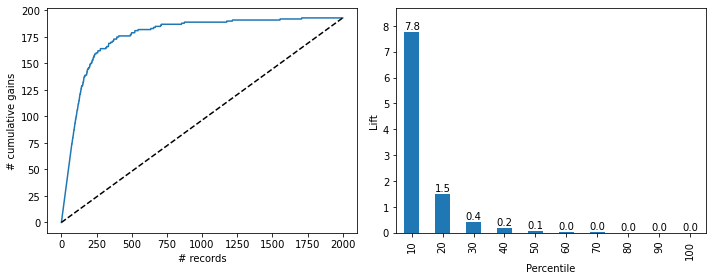

In [ ]:
df = logit_result.sort_values(by=['p(1)'], ascending=False)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

gainsChart(df.actual, ax=axes[0])
liftChart(df['p(1)'], title=False, ax=axes[1])

plt.tight_layout()
plt.show()

## Flight delays example

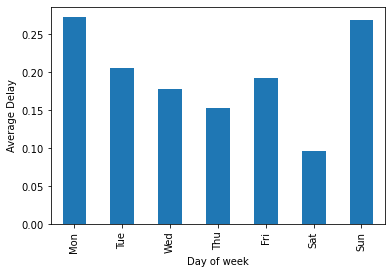

In [ ]:
delays_df = pd.read_excel('FlightDelays.xlsx', 'data')
# Create an indicator variable
delays_df['isDelayed'] = [1 if status == 'delayed' else 0 for status in delays_df['Flight Status']]

# group information by day of week and determine the average delay
averageDelay = delays_df.groupby(['DAY_WEEK'])['isDelayed'].mean()

# create a bar chart
ax = averageDelay.plot.bar(color='C0')
ax.set_xlabel('Day of week')
ax.set_ylabel('Average Delay')
_ = ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

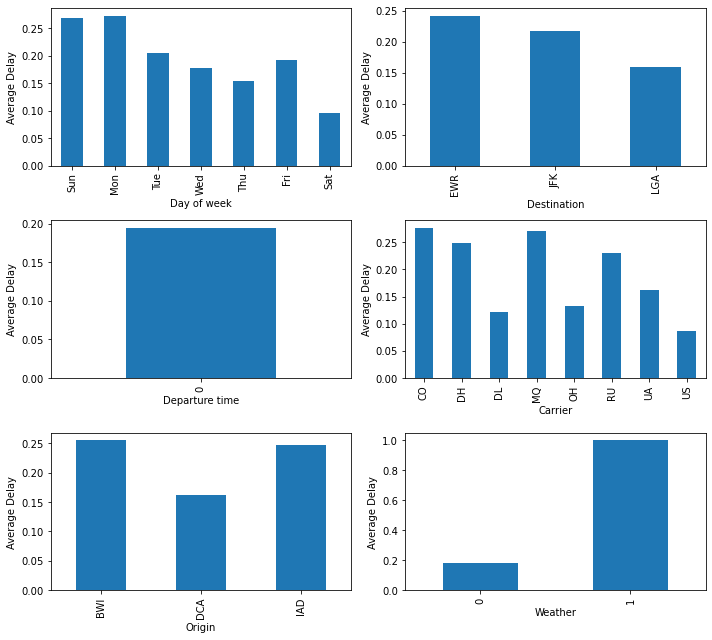

In [ ]:
def createGraph(group, xlabel, axis):
    groupAverage = delays_df.groupby([group])['isDelayed'].mean()
    if group == 'DAY_WEEK': # rotate so that display starts on Sunday
        groupAverage = groupAverage.reindex(index=np.roll(groupAverage.index,1))
        groupAverage.index = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
    ax = groupAverage.plot.bar(color='C0', ax=axis)
    ax.set_ylabel('Average Delay')
    ax.set_xlabel(xlabel)
    return ax

def graphDepartureTime(xlabel, axis):
    temp_df = pd.DataFrame({'CRS_DEP_TIME': delays_df['CRS_DEP_TIME'] // 100,
                            'isDelayed': delays_df['isDelayed']})
    groupAverage = temp_df.groupby(['CRS_DEP_TIME'])['isDelayed'].mean()
    ax = groupAverage.plot.bar(color='C0', ax=axis)
    ax.set_xlabel(xlabel); ax.set_ylabel('Average Delay')

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 9))

createGraph('DAY_WEEK', 'Day of week', axis=axes[0][0])
createGraph('DEST', 'Destination', axis=axes[0][1])
graphDepartureTime('Departure time', axis=axes[1][0])
createGraph('CARRIER', 'Carrier', axis=axes[1][1])
createGraph('ORIGIN', 'Origin', axis=axes[2][0])
createGraph('Weather', 'Weather', axis=axes[2][1])
plt.tight_layout()

plt.show()

## Comparing origin, day of week, and carrier

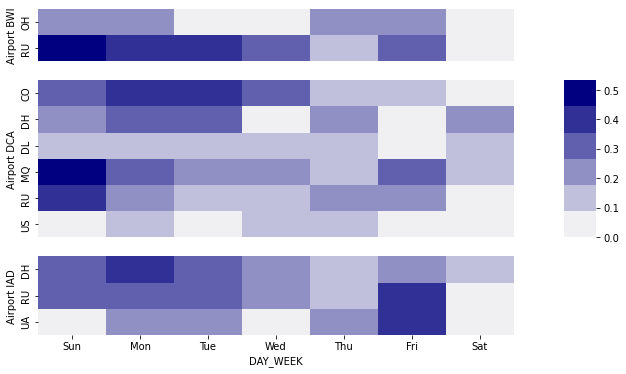

In [ ]:
agg = delays_df.groupby(['ORIGIN', 'DAY_WEEK', 'CARRIER']).isDelayed.mean()
agg = agg.reset_index()

# Define the layout of the graph
height_ratios = []
for i, origin in enumerate(sorted(delays_df.ORIGIN.unique())):
    height_ratios.append(len(agg[agg.ORIGIN == origin].CARRIER.unique()))
gridspec_kw = {'height_ratios': height_ratios, 'width_ratios': [15, 1]}
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 6),
                         gridspec_kw = gridspec_kw)
axes[0, 1].axis('off')
axes[2, 1].axis('off')

maxIsDelay = agg.isDelayed.max()
for i, origin in enumerate(sorted(delays_df.ORIGIN.unique())):
    data = pd.pivot_table(agg[agg.ORIGIN == origin], values='isDelayed', aggfunc=np.sum,
                          index=['CARRIER'], columns=['DAY_WEEK'])
    data = data[[7, 1, 2, 3, 4, 5, 6]]  # Shift last columns to first
    ax = sns.heatmap(data, ax=axes[i][0], vmin=0, vmax=maxIsDelay,
                     cbar_ax=axes[1][1], cmap=sns.light_palette("navy"))
    ax.set_xticklabels(['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])
    if i != 2:
        ax.get_xaxis().set_visible(False)
    ax.set_ylabel('Airport ' + origin)


plt.show()

## Logistic Regression modeling

In [ ]:
# convert to categorical
delays_df.DAY_WEEK = delays_df.DAY_WEEK.astype('category')

# create hourly bins departure time
delays_df.CRS_DEP_TIME = [round(t / 100) for t in delays_df.CRS_DEP_TIME]
delays_df.CRS_DEP_TIME = delays_df.CRS_DEP_TIME.astype('category')

predictors = ['DAY_WEEK', 'CRS_DEP_TIME', 'ORIGIN', 'DEST', 'CARRIER', 'Weather']
outcome = 'isDelayed'

X = pd.get_dummies(delays_df[predictors], drop_first=True)
y = delays_df[outcome]
classes = ['ontime', 'delayed']

# split into training and validation
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4,
                                                      random_state=1)

logit_full = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_full.fit(train_X, train_y)

pd.set_option('display.width', 95)
pd.set_option('precision',3)
pd.set_option('max_columns', 33)
print('intercept ', logit_full.intercept_[0])

print(pd.DataFrame({'coeff': logit_full.coef_[0]}, index=X.columns).transpose())
print()
print('AIC', AIC_score(valid_y, logit_full.predict(valid_X), df=len(train_X.columns) + 1))
pd.reset_option('display.width')
pd.reset_option('precision')
pd.reset_option('max_columns')

OptionError: 'Pattern matched multiple keys'

## Confusion Matrix and Gains Chart

Confusion Matrix (Accuracy 0.8331)

        Prediction
 Actual  ontime delayed
 ontime     714       0
delayed     147      20


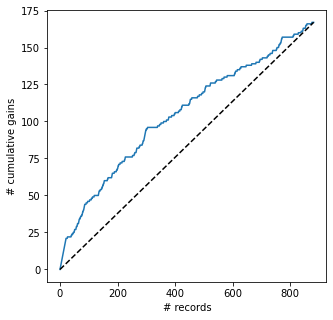

In [ ]:
logit_reg_pred = logit_full.predict_proba(valid_X)
full_result = pd.DataFrame({'actual': valid_y,
                            'p(0)': [p[0] for p in logit_reg_pred],
                            'p(1)': [p[1] for p in logit_reg_pred],
                            'predicted': logit_full.predict(valid_X)})
full_result = full_result.sort_values(by=['p(1)'], ascending=False)

# confusion matrix
classificationSummary(full_result.actual, full_result.predicted, class_names=classes)

gainsChart(full_result.actual, figsize=[5, 5])

plt.show()

## Full model

In [ ]:
delays_df = pd.read_excel('FlightDelays.xlsx', 'data')
delays_df['isDelayed'] = [1 if status == 'delayed' else 0
                          for status in delays_df['Flight Status']]
delays_df['CRS_DEP_TIME'] = [round(t / 100) for t in delays_df['CRS_DEP_TIME']]
delays_red_df = pd.DataFrame({
    'Sun_Mon' : [1 if d in (1, 7) else 0 for d in delays_df.DAY_WEEK],
    'Weather' : delays_df.Weather,
    'CARRIER_CO_MQ_DH_RU' : [1 if d in ("CO", "MQ", "DH", "RU") else 0
                             for d in delays_df.CARRIER],
    'MORNING' : [1 if d in (6, 7, 8, 9) else 0 for d in delays_df.CRS_DEP_TIME],
    'NOON' : [1 if d in (10, 11, 12, 13) else 0 for d in delays_df.CRS_DEP_TIME],
    'AFTER2P' : [1 if d in (14, 15, 16, 17, 18) else 0 for d in delays_df.CRS_DEP_TIME],
    'EVENING' : [1 if d in (19, 20) else 0 for d in delays_df.CRS_DEP_TIME],
    'isDelayed' : [1 if status == 'delayed' else 0 for status in delays_df['Flight Status']],
})

X = delays_red_df.drop(columns=['isDelayed'])
y = delays_red_df['isDelayed']
classes = ['ontime', 'delayed']

# split into training and validation
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4,
                                                      random_state=1)

logit_red = LogisticRegressionCV(penalty="l1", solver='liblinear', cv=5)
logit_red.fit(train_X, train_y)

pd.set_option('display.width', 100)
print('regularization', logit_red.C_)
print('intercept ', logit_red.intercept_[0])
print(pd.DataFrame({'coeff': logit_red.coef_[0]}, index=X.columns).transpose())
pd.reset_option('display.width')
print('AIC', AIC_score(valid_y, logit_red.predict(valid_X), df=len(train_X.columns) + 1))


# confusion matrix
classificationSummary(valid_y, logit_red.predict(valid_X), class_names=classes)

regularization [2.7825594]
intercept  -2.2875074087982754
        Sun_Mon   Weather  CARRIER_CO_MQ_DH_RU   MORNING      NOON   AFTER2P  EVENING
coeff  0.577947  4.977942             1.298892 -0.583188 -0.665765 -0.055072  0.56097
AIC 934.6153607819037
Confusion Matrix (Accuracy 0.8343)

        Prediction
 Actual  ontime delayed
 ontime     711       3
delayed     143      24


## Comparison of full model and reduced model

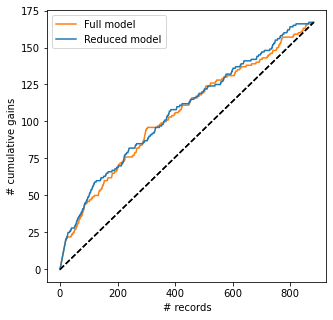

In [ ]:
logit_reg_proba = logit_red.predict_proba(valid_X)
red_result = pd.DataFrame({'actual': valid_y,
                            'p(0)': [p[0] for p in logit_reg_proba],
                            'p(1)': [p[1] for p in logit_reg_proba],
                            'predicted': logit_red.predict(valid_X),
                          })
red_result = red_result.sort_values(by=['p(1)'], ascending=False)

ax = gainsChart(full_result.actual, label='Full model', color='C1', figsize=[5, 5])
ax = gainsChart(red_result.actual, label='Reduced model', color='C0', ax=ax)
ax.legend()

plt.show()